# Imports/config

In [2]:
# Install required packages
!pip install squigglepy

In [3]:
# Squigglepy documentation: https://github.com/rethinkpriorities/squigglepy
import squigglepy as sq
import numpy as np
import matplotlib.pyplot as plt
from squigglepy.numbers import K, M, B
from pprint import pprint
import pandas as pd

sq.set_seed(42)
np.random.seed(42)

In [19]:
# Helper Functions
# ================

from scipy import stats

def generate_lognormal_from_percentiles(x_lower, x_upper, p_lower, p_upper, n=10000):
    """
    Generate lognormal distribution samples from percentile constraints.

    Args:
        x_lower: Lower bound value at p_lower percentile
        x_upper: Upper bound value at p_upper percentile
        p_lower: Lower percentile (e.g., 20 for 20th percentile)
        p_upper: Upper percentile (e.g., 80 for 80th percentile)
        n: Number of samples to generate

    Returns:
        numpy array of lognormal samples
    """
    z_lower = stats.norm.ppf(p_lower / 100)
    z_upper = stats.norm.ppf(p_upper / 100)

    mu = (np.log(x_lower) * z_upper - np.log(x_upper) * z_lower) / (z_upper - z_lower)
    sigma = (np.log(x_upper) - np.log(x_lower)) / (z_upper - z_lower)

    return np.random.lognormal(mean=mu, sigma=sigma, size=n)


def print_percentile_results(samples, title="Percentiles", percentiles=[25, 50, 75]):
    """Print formatted percentile results."""
    results = sq.get_percentiles(samples, percentiles=percentiles, digits=0)

    print(f"{title}:")
    for percentile, value in results.items():
        print(f"  {percentile}: {value:,}")

    return results


def fy_to_decimal_year(fy_string):
    """
    Convert Nvidia fiscal year quarter string to decimal year.

    Nvidia's fiscal year ends in January, so:
    - FY26 Q1 ends April 2025 (Q1: Feb-Apr)
    - FY26 Q2 ends July 2025 (Q2: May-Jul)
    - FY26 Q3 ends October 2025 (Q3: Aug-Oct)
    - FY26 Q4 ends January 2026 (Q4: Nov-Jan)

    Args:
        fy_string (str): Fiscal year string like "FY23Q1" or "FY26Q2"

    Returns:
        float: Decimal year representing the end date of the quarter

    """
    # Parse the fiscal year and quarter
    fy_part = fy_string[:4]  # "FY26"
    q_part = fy_string[4:]   # "Q1"

    # Extract fiscal year number (last 2 digits)
    fy_num = int(fy_part[2:])

    # Convert 2-digit year to 4-digit year
    # Assuming fiscal years 00-99 map to 2000-2099
    if fy_num < 50:  # Adjust this threshold as needed
        fiscal_year = 2000 + fy_num
    else:
        fiscal_year = 1900 + fy_num

    # Extract quarter number
    quarter = int(q_part[1:])

    # Map quarters to their end months and approximate decimal positions
    quarter_end_map = {
        1: (4, 0.32),   # Q1 ends in April (4/12 ≈ 0.32)
        2: (7, 0.57),   # Q2 ends in July (7/12 ≈ 0.57)
        3: (10, 0.82),  # Q3 ends in October (10/12 ≈ 0.82)
        4: (1, 0.07)    # Q4 ends in January of next calendar year
    }

    end_month, decimal_fraction = quarter_end_map[quarter]

    # For Q4, the calendar year is the fiscal year
    # For Q1-Q3, the calendar year is fiscal year - 1
    if quarter == 4:
        calendar_year = fiscal_year
    else:
        calendar_year = fiscal_year - 1

    return calendar_year + decimal_fraction


# wrapper for sq.to, with default credibility of 80% (library default is 90)
def sq_distribution(x_lower, x_upper, credibility=80, lclip = None, rclip = None):
    return sq.to(x_lower, x_upper, credibility, lclip, rclip)

# Microsoft-based estimate

In [5]:
# Import Microsoft CSV data
microsoft_df = pd.read_csv('microsoft_cumulative.csv')

# Display basic info about the dataset
print("Microsoft CSV Data Shape:", microsoft_df.shape)
print("\nColumn names:")
print(microsoft_df.columns.tolist())
print("\nFirst few rows:")
microsoft_df.head()


Microsoft CSV Data Shape: (14, 8)

Column names:
['Quarter', 'decimal_year', 'h100_equivs_25th', 'h100_equivs_median', 'h100_equivs_75th', 'cumulative_25th', 'cumulative_median', 'cumulative_75th']

First few rows:


,Quarter,decimal_year,h100_equivs_25th,h100_equivs_median,h100_equivs_75th,cumulative_25th,cumulative_median,cumulative_75th
0,FY23Q1,2022.32,16037.642459,18201.025426,20632.797651,16037.642459,18201.025426,20632.797651
1,FY23Q2,2022.57,16383.350408,18609.108790,21048.656513,32420.992867,36810.134217,41681.454164
2,FY23Q3,2022.82,17219.305146,19331.234030,21670.159620,49640.298013,56141.368246,63351.613784
3,FY23Q4,2023.07,19075.489959,21497.052981,24291.404617,68715.787972,77638.421227,87643.018401
4,FY24Q1,2023.32,23549.718623,26989.654532,30829.685506,92265.506595,104628.075759,118472.703907


# OpenAI's Microsoft Cloud Compute

In [ ]:
# Define distributions for the two key variables
cloud_share_of_msft_compute = sq_distribution(0.6, 0.9, rclip = 1)  
openai_share_of_cloud_compute = sq_distribution(0.5, 0.8, rclip = 1)

# Calculate OpenAI's share of total Microsoft compute
openai_share_of_total_msft = cloud_share_of_msft_compute * openai_share_of_cloud_compute

# Sample the distribution
samples = openai_share_of_total_msft @ 10000

print("OpenAI's Share of Microsoft's Total Compute:")
print(f"Mean: {np.mean(samples):.3f} ({np.mean(samples)*100:.1f}%)")
print(f"Std Dev: {np.std(samples):.3f}")
print()

OpenAI's Share of Microsoft's Total Compute:
Mean: 0.477 (47.7%)
Std Dev: 0.117



In [17]:
microsoft_df.head()

,Quarter,decimal_year,h100_equivs_25th,h100_equivs_median,h100_equivs_75th,cumulative_25th,cumulative_median,cumulative_75th
0,FY23Q1,2022.32,16037.642459,18201.025426,20632.797651,16037.642459,18201.025426,20632.797651
1,FY23Q2,2022.57,16383.350408,18609.108790,21048.656513,32420.992867,36810.134217,41681.454164
2,FY23Q3,2022.82,17219.305146,19331.234030,21670.159620,49640.298013,56141.368246,63351.613784
3,FY23Q4,2023.07,19075.489959,21497.052981,24291.404617,68715.787972,77638.421227,87643.018401
4,FY24Q1,2023.32,23549.718623,26989.654532,30829.685506,92265.506595,104628.075759,118472.703907


OpenAI's Compute Distribution Over Time
FY23Q1: P25=  6,923, P50=  8,492, P75= 10,434
FY23Q2: P25= 13,957, P50= 17,096, P75= 20,892
FY23Q3: P25= 21,208, P50= 26,080, P75= 31,992
FY23Q4: P25= 29,410, P50= 36,166, P75= 43,960
FY24Q1: P25= 39,646, P50= 48,672, P75= 59,597
FY24Q2: P25= 63,989, P50= 79,195, P75= 97,336
FY24Q3: P25=100,519, P50=124,845, P75=154,564
FY24Q4: P25=163,583, P50=203,159, P75=252,963
FY25Q1: P25=225,895, P50=281,065, P75=348,873
FY25Q2: P25=299,108, P50=370,334, P75=461,290
FY25Q3: P25=383,319, P50=475,797, P75=591,998
FY25Q4: P25=501,950, P50=623,811, P75=770,502
FY26Q1: P25=664,241, P50=818,967, P75=1,000,387
FY26Q2: P25=844,813, P50=1,028,332, P75=1,259,960

OpenAI Compute Growth Summary:
From FY23Q1 to FY26Q2:
P50 growth: 8,492 → 1,028,332 (121.1x)


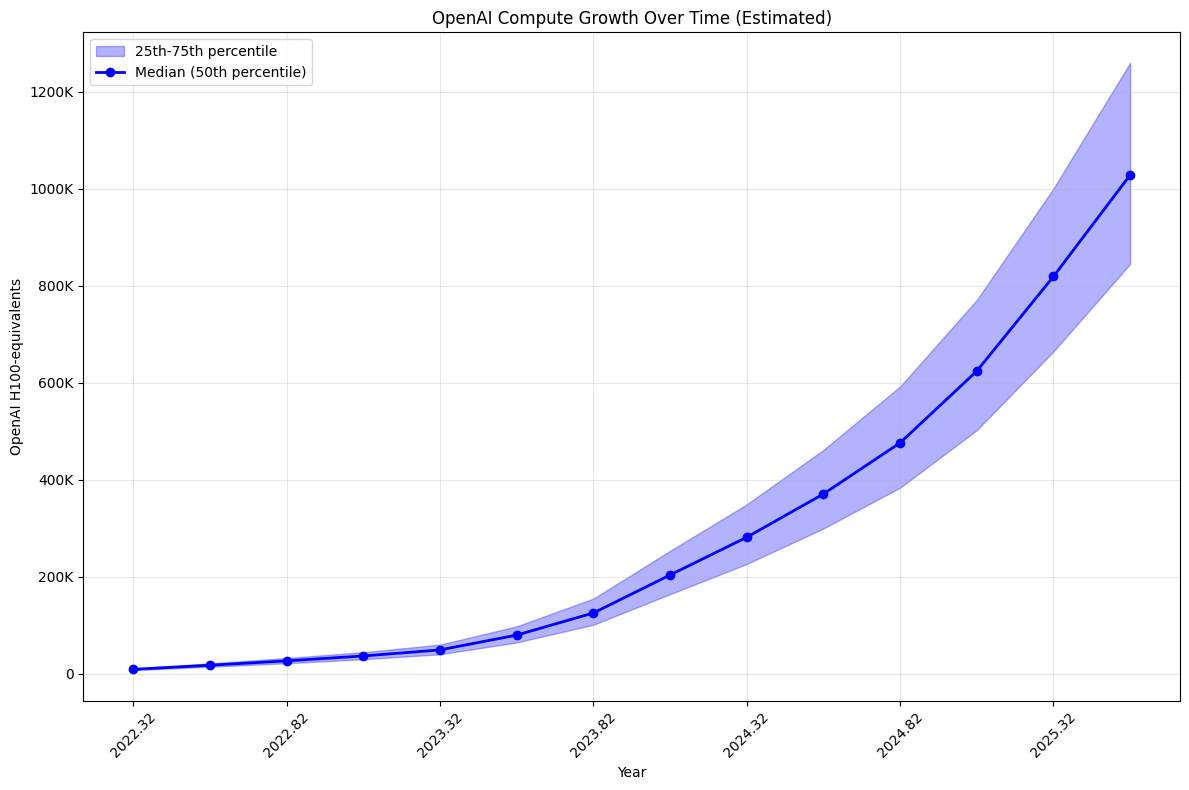

,Quarter,decimal_year,P25,P50,P75
0,FY23Q1,2022.32,6923,8492,10434
1,FY23Q2,2022.57,13957,17096,20892
2,FY23Q3,2022.82,21208,26080,31992
3,FY23Q4,2023.07,29410,36166,43960
4,FY24Q1,2023.32,39646,48672,59597
5,FY24Q2,2023.57,63989,79195,97336
6,FY24Q3,2023.82,100519,124845,154564
7,FY24Q4,2024.07,163583,203159,252963
8,FY25Q1,2024.32,225895,281065,348873
9,FY25Q2,2024.57,299108,370334,461290


In [ ]:
# OpenAI's compute distribution over time (quarter by quarter)
print("OpenAI's Compute Distribution Over Time")
print("="*50)

results = []

# multiplier for GPUs Microsoft rented from other clouds, especially CoreWeave and Oracle
# this was likely minor/neglible before 2024
# other_cloud_multiplier_22_23 = sq_distribution(1, 1.05, lclip = 1)
other_cloud_multiplier = sq_distribution(1.05, 1.2, lclip = 1)

for _, row in microsoft_df.iterrows():
    quarter = row['Quarter']
    decimal_year = row['decimal_year']
    
    # Create distribution for Microsoft's cumulative compute using 25th and 75th percentiles
    msft_compute_dist = sq_distribution(row['cumulative_25th'], row['cumulative_75th'], credibility=50)
    if decimal_year > 2024.0:
        msft_compute_dist = msft_compute_dist * other_cloud_multiplier
    # else: 
    #     msft_compute_dist = msft_compute_dist * other_cloud_multiplier_22_23
    
    # Multiply by OpenAI's share distribution
    openai_compute_dist = msft_compute_dist * openai_share_of_total_msft
    
    # Sample the distribution
    openai_samples = openai_compute_dist @ 10000
    
    # Calculate percentiles
    percentiles = sq.get_percentiles(openai_samples, percentiles=[25, 50, 75], digits=0)
    
    # Store results
    quarter_result = {
        'Quarter': quarter,
        'decimal_year': row['decimal_year'],
        'P25': percentiles[25],
        'P50': percentiles[50], 
        'P75': percentiles[75]
    }
    results.append(quarter_result)
    
    # Print results for this quarter
    print(f"{quarter}: P25={percentiles[25]:>7,.0f}, P50={percentiles[50]:>7,.0f}, P75={percentiles[75]:>7,.0f}")

# Convert to DataFrame for easier analysis
openai_results_df = pd.DataFrame(results)

print(f"\nOpenAI Compute Growth Summary:")
print(f"From {openai_results_df.iloc[0]['Quarter']} to {openai_results_df.iloc[-1]['Quarter']}:")
print(f"P50 growth: {openai_results_df.iloc[0]['P50']:,.0f} → {openai_results_df.iloc[-1]['P50']:,.0f} ({openai_results_df.iloc[-1]['P50']/openai_results_df.iloc[0]['P50']:.1f}x)")

# Plot the results
plt.figure(figsize=(12, 8))

# Plot the percentile bands
plt.fill_between(openai_results_df['decimal_year'], 
                 openai_results_df['P25'], 
                 openai_results_df['P75'], 
                 alpha=0.3, label='25th-75th percentile', color='blue')

plt.plot(openai_results_df['decimal_year'], openai_results_df['P50'], 
         'o-', linewidth=2, label='Median (50th percentile)', color='blue')

plt.xlabel('Year')
plt.ylabel('OpenAI H100-equivalents')
plt.title('OpenAI Cloud Compute Growth Over Time (Estimated)')
plt.legend()
plt.grid(True, alpha=0.3)
# plt.yscale('log')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'))

# Add quarter labels on x-axis
plt.xticks(openai_results_df['decimal_year'][::2], 
           # openai_results_df['Quarter'][::2], 
           rotation=45)

plt.tight_layout()
plt.show()

openai_results_df

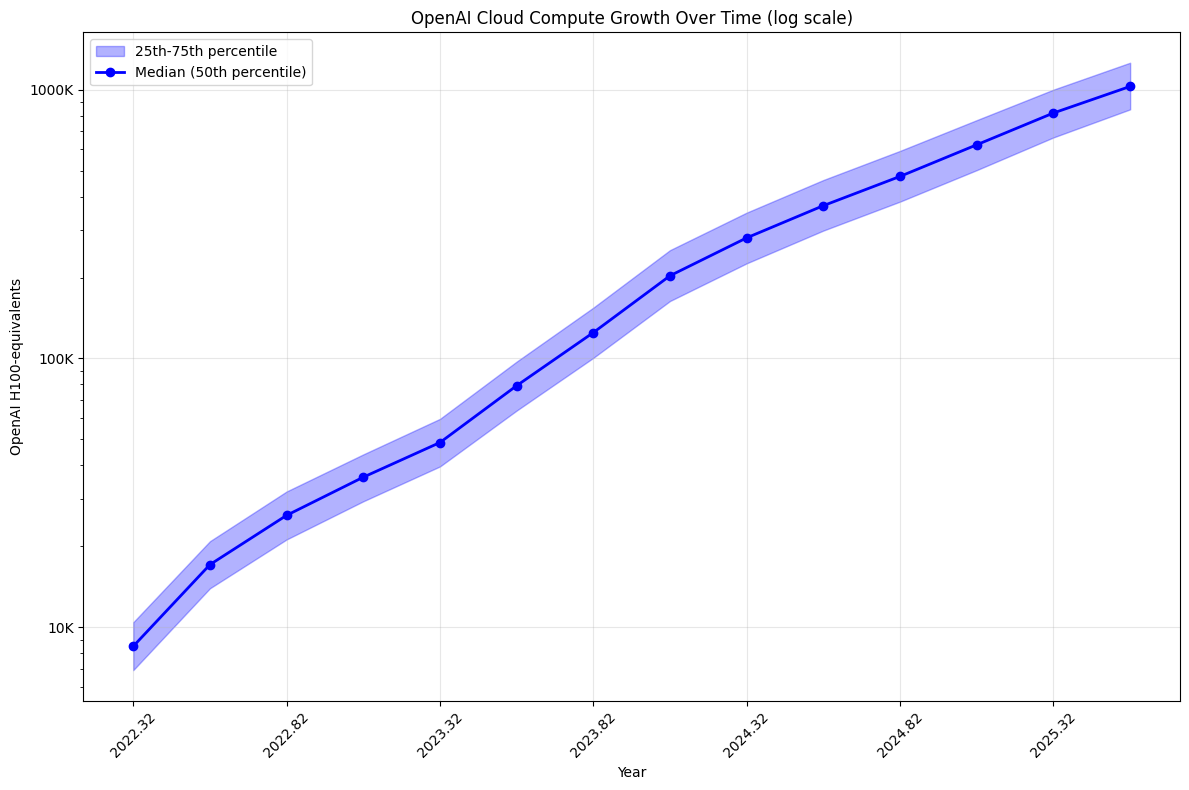

In [27]:
# Plot the results
plt.figure(figsize=(12, 8))

# Plot the percentile bands
plt.fill_between(openai_results_df['decimal_year'], 
                 openai_results_df['P25'], 
                 openai_results_df['P75'], 
                 alpha=0.3, label='25th-75th percentile', color='blue')

plt.plot(openai_results_df['decimal_year'], openai_results_df['P50'], 
         'o-', linewidth=2, label='Median (50th percentile)', color='blue')

plt.xlabel('Year')
plt.ylabel('OpenAI H100-equivalents')
plt.title('OpenAI Cloud Compute Growth Over Time (log scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'))

# Add quarter labels on x-axis
plt.xticks(openai_results_df['decimal_year'][::2], 
           # openai_results_df['Quarter'][::2], 
           rotation=45)

plt.tight_layout()
plt.show()

Adjusting for GPU Acquisition to Accessibility Delay
FY23Q1:
  Original P50:   8,528 → Adjusted P50:   8,528 (1.00x)
FY23Q2:
  Original P50:  17,098 → Adjusted P50:  11,357 (0.66x)
FY23Q3:
  Original P50:  25,998 → Adjusted P50:  20,540 (0.79x)
FY23Q4:
  Original P50:  36,299 → Adjusted P50:  29,888 (0.82x)
FY24Q1:
  Original P50:  48,885 → Adjusted P50:  41,165 (0.84x)
FY24Q2:
  Original P50:  79,510 → Adjusted P50:  60,205 (0.76x)
FY24Q3:
  Original P50: 123,878 → Adjusted P50:  95,931 (0.77x)
FY24Q4:
  Original P50: 179,090 → Adjusted P50: 144,379 (0.81x)
FY25Q1:
  Original P50: 250,760 → Adjusted P50: 205,870 (0.82x)
FY25Q2:
  Original P50: 329,593 → Adjusted P50: 280,396 (0.85x)
FY25Q3:
  Original P50: 427,499 → Adjusted P50: 366,454 (0.86x)
FY25Q4:
  Original P50: 558,481 → Adjusted P50: 477,856 (0.86x)
FY26Q1:
  Original P50: 730,956 → Adjusted P50: 626,626 (0.86x)
FY26Q2:
  Original P50: 917,254 → Adjusted P50: 804,942 (0.88x)

Delay Adjustment Summary:
Average reduction factor

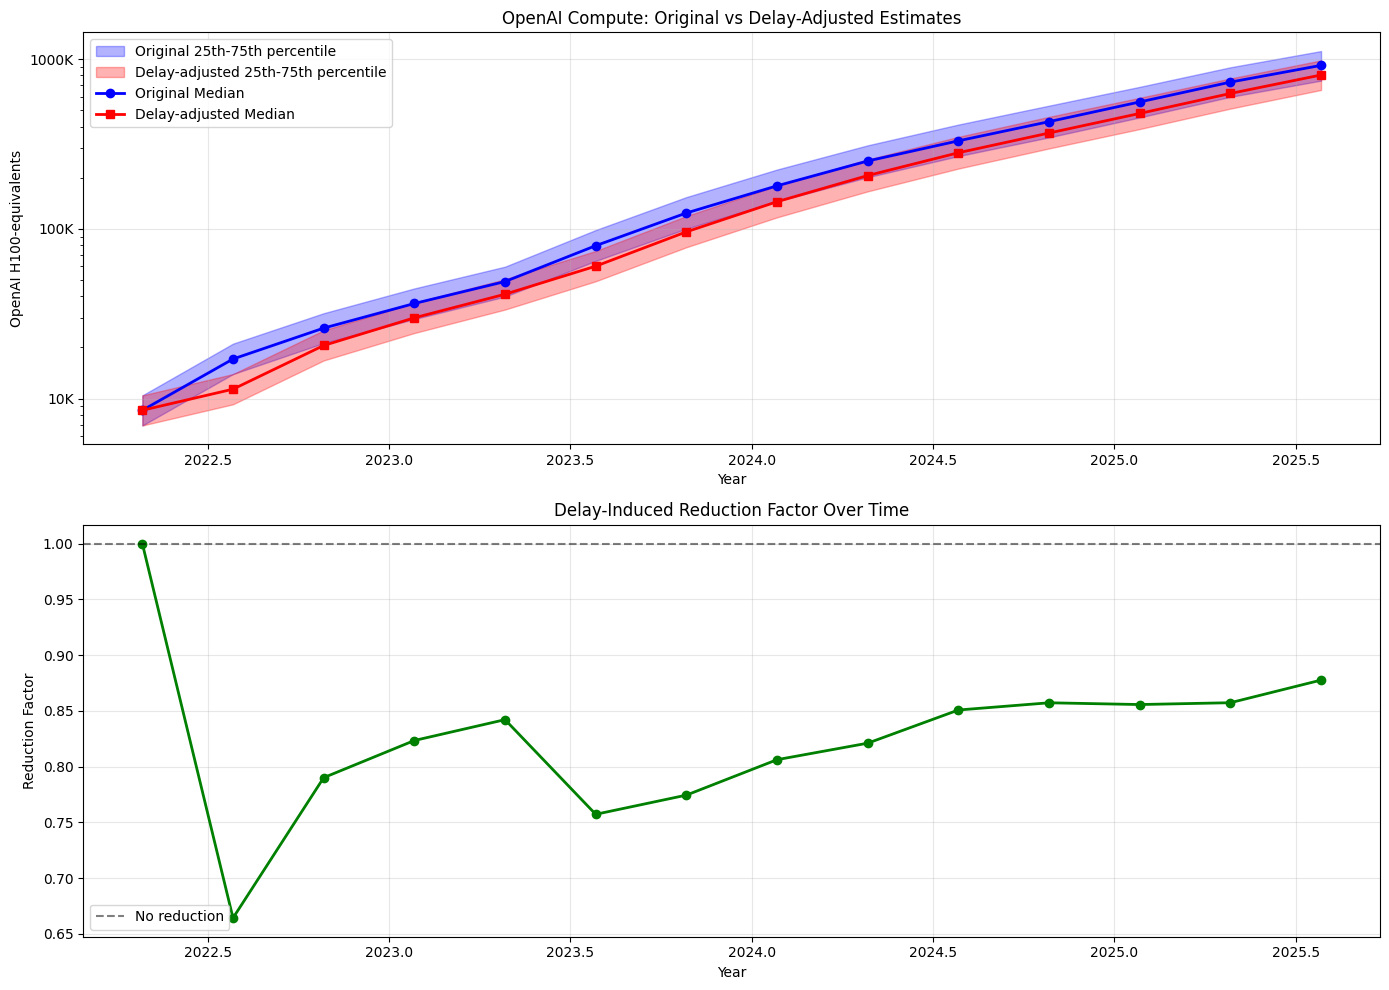


Adjusted Results DataFrame:


,Quarter,Original_P50,Adjusted_P50,Reduction_Factor
0,FY23Q1,8528,8528.000000,1.000000
1,FY23Q2,17098,11356.621291,0.664208
2,FY23Q3,25998,20540.003437,0.790061
3,FY23Q4,36299,29887.916563,0.823381
4,FY24Q1,48885,41164.974122,0.842078
5,FY24Q2,79510,60205.060940,0.757201
6,FY24Q3,123878,95930.732389,0.774397
7,FY24Q4,179090,144378.583816,0.806179
8,FY25Q1,250760,205870.359393,0.820986
9,FY25Q2,329593,280395.957656,0.850734


In [15]:
# Adjust for GPU acquisition to accessibility delay
print("Adjusting for GPU Acquisition to Accessibility Delay")
print("="*55)

# Define delay distribution (1-3 months)
delay_months = sq_distribution(1, 3, credibility=80)

# Function to interpolate between quarterly values using exponential growth assumption
def interpolate_exponential_growth(df, target_time):
    """
    Interpolate values assuming exponential growth between quarters.
    Returns interpolated P25, P50, P75 values.
    """
    # Find the two quarters that bracket our target time
    before_idx = df[df['decimal_year'] <= target_time]['decimal_year'].idxmax() if len(df[df['decimal_year'] <= target_time]) > 0 else 0
    after_idx = df[df['decimal_year'] > target_time]['decimal_year'].idxmin() if len(df[df['decimal_year'] > target_time]) > 0 else len(df) - 1
    
    # Handle edge cases
    if before_idx == after_idx:
        if target_time <= df.iloc[0]['decimal_year']:
            return df.iloc[0]['P25'], df.iloc[0]['P50'], df.iloc[0]['P75']
        else:
            return df.iloc[-1]['P25'], df.iloc[-1]['P50'], df.iloc[-1]['P75']
    
    # Get the bracketing data points
    before = df.iloc[before_idx]
    after = df.iloc[after_idx]
    
    # Calculate interpolation factor
    time_fraction = (target_time - before['decimal_year']) / (after['decimal_year'] - before['decimal_year'])
    
    # Exponential interpolation: value = before_value * (after_value/before_value)^time_fraction
    p25_interp = before['P25'] * (after['P25'] / before['P25']) ** time_fraction
    p50_interp = before['P50'] * (after['P50'] / before['P50']) ** time_fraction
    p75_interp = before['P75'] * (after['P75'] / before['P75']) ** time_fraction
    
    return p25_interp, p50_interp, p75_interp

# Create adjusted results
adjusted_results = []

for _, row in openai_results_df.iterrows():
    quarter = row['Quarter']
    current_time = row['decimal_year']
    
    # Sample delay for this estimate
    delay_samples = delay_months @ 1000
    
    # For each delay sample, calculate the adjusted estimate
    adjusted_p25_samples = []
    adjusted_p50_samples = []
    adjusted_p75_samples = []
    
    for delay in delay_samples:
        # Convert delay to decimal years (assuming 12 months per year)
        delay_years = delay / 12
        
        # Calculate the time when GPUs were acquired
        acquisition_time = current_time - delay_years
        
        # Interpolate the values at acquisition time
        p25_at_acquisition, p50_at_acquisition, p75_at_acquisition = interpolate_exponential_growth(
            openai_results_df, acquisition_time
        )
        
        adjusted_p25_samples.append(p25_at_acquisition)
        adjusted_p50_samples.append(p50_at_acquisition)
        adjusted_p75_samples.append(p75_at_acquisition)
    
    # Calculate percentiles of the adjusted estimates
    adj_p25 = np.percentile(adjusted_p25_samples, 50)  # Median of adjusted P25s
    adj_p50 = np.percentile(adjusted_p50_samples, 50)  # Median of adjusted P50s  
    adj_p75 = np.percentile(adjusted_p75_samples, 50)  # Median of adjusted P75s
    
    # Store results
    adjusted_quarter_result = {
        'Quarter': quarter,
        'decimal_year': current_time,
        'Original_P25': row['P25'],
        'Original_P50': row['P50'],
        'Original_P75': row['P75'],
        'Adjusted_P25': adj_p25,
        'Adjusted_P50': adj_p50,
        'Adjusted_P75': adj_p75,
        'Reduction_Factor': adj_p50 / row['P50']
    }
    adjusted_results.append(adjusted_quarter_result)
    
    # Print comparison
    print(f"{quarter}:")
    print(f"  Original P50: {row['P50']:>7,.0f} → Adjusted P50: {adj_p50:>7,.0f} ({adj_p50/row['P50']:.2f}x)")

# Convert to DataFrame
adjusted_df = pd.DataFrame(adjusted_results)

print(f"\nDelay Adjustment Summary:")
print(f"Average reduction factor: {adjusted_df['Reduction_Factor'].mean():.2f}x")
print(f"Range of reduction factors: {adjusted_df['Reduction_Factor'].min():.2f}x to {adjusted_df['Reduction_Factor'].max():.2f}x")

# Plot comparison
plt.figure(figsize=(14, 10))

# Subplot 1: Original vs Adjusted estimates
plt.subplot(2, 1, 1)
plt.fill_between(adjusted_df['decimal_year'], 
                 adjusted_df['Original_P25'], 
                 adjusted_df['Original_P75'], 
                 alpha=0.3, label='Original 25th-75th percentile', color='blue')

plt.fill_between(adjusted_df['decimal_year'], 
                 adjusted_df['Adjusted_P25'], 
                 adjusted_df['Adjusted_P75'], 
                 alpha=0.3, label='Delay-adjusted 25th-75th percentile', color='red')

plt.plot(adjusted_df['decimal_year'], adjusted_df['Original_P50'], 
         'o-', linewidth=2, label='Original Median', color='blue')
plt.plot(adjusted_df['decimal_year'], adjusted_df['Adjusted_P50'], 
         's-', linewidth=2, label='Delay-adjusted Median', color='red')

plt.xlabel('Year')
plt.ylabel('OpenAI H100-equivalents')
plt.title('OpenAI Compute: Original vs Delay-Adjusted Estimates')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'))

# Subplot 2: Reduction factors over time
plt.subplot(2, 1, 2)
plt.plot(adjusted_df['decimal_year'], adjusted_df['Reduction_Factor'], 
         'o-', linewidth=2, color='green')
plt.xlabel('Year')
plt.ylabel('Reduction Factor')
plt.title('Delay-Induced Reduction Factor Over Time')
plt.grid(True, alpha=0.3)
plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='No reduction')
plt.legend()

plt.tight_layout()
plt.show()

# Display the adjusted results
print("\nAdjusted Results DataFrame:")
adjusted_df[['Quarter', 'Original_P50', 'Adjusted_P50', 'Reduction_Factor']]